# Capstone Project

## Imports

In [1]:
import pandas as pd
import numpy as np

# plotting
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import squarify
import plotly.express as px

# Google Cloud BigQuery
from google.cloud import bigquery
from google.cloud import storage
from google.oauth2 import service_account
from google.cloud.bigquery import Dataset
import google.cloud.bigquery_storage_v1.client
from functools import partialmethod

#Dimensionality reduction
from sklearn.manifold import TSNE

# modelling
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

# performance metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_samples, silhouette_score

# processing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import os
import gc

In [2]:
sns.set_style("darkgrid")
plt.style.use('seaborn-darkgrid')

In [3]:
# check location
os.getcwd()

'C:\\Users\\sakina.sakdun\\Documents\\GitHub\\IOD\\Projects'

# Dataset: E-commerce User Behaviour 

Dataset contains customer behavior data (csv files) for 3 months (from January 2020 to March 2020) from a large multi-category online store.
> Source Link: https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store?select=2019-Oct.csv

Due to large files, raw datasets are uploaded on BigQuery Google Storage Bucket. We will retrieve the csv files from there.

## Data Dictionary

| Columns                | Definition                                                                                  | Key                                                              |
|------------------------|---------------------------------------------------------------------------------------------|------------------------------------------------------------------|
| event_time             | Time when event happened at (in UTC)                                                        |                                                                  |
| event_type             | Four kinds of events                                                                        | - view (a user viewed a product)                                 |
|                        |                                                                                             | - cart (a user added a product to shopping cart)                 |
|                        |                                                                                             | - purchase (a user purchased a product)                          |    
| product_id             | ID of a product                                                                             |                                                                  |
| category_id            | Product's category ID                                                                       |                                                                  |
| category_code          | Product's category taxonomy (code name).                                                    |                                                                  |
|                        | Usually present for meaningful categories and skipped for different kinds of accessories.   |                                                                  |
| brand                  | Downcased string of brand name                                                              |                                                                  |
| price                  | Float price of a product. Present.                                                          |                                                                  |
| user_id                | Permanent user ID                                                                           |                                                                  |
| user_session           | Temporary user's session ID. Same for each user's session.                                  |                                                                  |
|                        | Is changed every time user come back to online store from a long pause.                     |                                                                  |

## Google Storage BigQuery

In [5]:
## Retrieving keys
key_path = 'dat/iod-capstone-84fa46ac3809.json'

# my project name = 'iod-capstone'
storage_client = storage.Client.from_service_account_json(key_path)
client = bigquery.Client.from_service_account_json(key_path, project = 'iod-capstone')
print(client.project)

iod-capstone


In [6]:
# list of datasets in my project 'iod-capstone'
datasets = list(client.list_datasets())

# dataset referencing
for index in range(0, len(datasets)):
    print(datasets[index].dataset_id)

ecommerce_customers
ecommerce_events
ecommerce_users


In [7]:
dataset_id = 'ecommerce_events'
dataset_ref = client.dataset(dataset_id)
dataset_ref

DatasetReference('iod-capstone', 'ecommerce_events')

### List of Events Tables 

In [8]:
# list of tables in my dataset 'ecommerce_events'
dataset_id = 'ecommerce_events'
tables = client.list_tables(dataset_id)

print("Tables contained in '{}':".format(dataset_id))
for table in tables:
    print("{}.{}.{}".format(table.project, table.dataset_id, table.table_id))

Tables contained in 'ecommerce_events':
iod-capstone.ecommerce_events.events_2020_01
iod-capstone.ecommerce_events.events_2020_02
iod-capstone.ecommerce_events.events_2020_03
iod-capstone.ecommerce_events.events_2020_Q1


Note that the raw data tables are denoted by 'events_2020_01', 'events_2020_02' and 'events_2020_03'. I have combined it (union all tables) into one big data table 'events_2020_Q1'.

### Fetching Tables 

In [9]:
table_id = 'events_2020_Q1'  # combined dataset
table_ref = dataset_ref.table(table_id)

# API Request to get the table
table = client.get_table(table_ref) 

In [10]:
type(table)

google.cloud.bigquery.table.Table

In [11]:
# viewing schema
result = ["{0} {1}".format(schema.name,schema.field_type) for schema in table.schema]
print(result)

['event_time TIMESTAMP', 'event_type STRING', 'product_id INTEGER', 'category_id INTEGER', 'category_code STRING', 'brand STRING', 'price FLOAT', 'user_id INTEGER', 'user_session STRING']


In [12]:
# function to print a table schema:
def printTableSchema(aTable):
    schemas = list(aTable.schema)
    if schemas:
        print('Table schema for {}:'.format(aTable.table_id))
        for aSchema in schemas:
            print('\t{0} {1}'.format(aSchema.name, aSchema.field_type))
        found = True
    else:
        found = False
    return found

In [13]:
printTableSchema(table)

Table schema for events_2020_Q1:
	event_time TIMESTAMP
	event_type STRING
	product_id INTEGER
	category_id INTEGER
	category_code STRING
	brand STRING
	price FLOAT
	user_id INTEGER
	user_session STRING


True

### Events Table - Raw Dataset

In [19]:
# a function to turn BigQuery API request to DataFrame
def bigquery_to_dataframe(sql):
    # API request - fetches results
    query_job = client.query(sql)
    # Set a two hours timeout
    google.cloud.bigquery_storage_v1.client.BigQueryReadClient.read_rows = partialmethod(google.cloud.bigquery_storage_v1.client.BigQueryReadClient.read_rows, timeout=3600*2)
    # SQL query to DataFrame
    df = query_job.to_dataframe()
    df = pd.DataFrame(df)
    return df

In [21]:
# previewing only sample of 100 rows from events data
sql00 = """SELECT *
         FROM `iod-capstone.ecommerce_events.events_2020_Q1`
         LIMIT 100
      """

query_job = client.query(sql00)

In [22]:
events_q1_df = bigquery_to_dataframe(sql00)

In [23]:
events_q1_df.head(10)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-03-11 03:49:49+00:00,view,100089456,2053013554155487563,computers.components.motherboard,defacto,12.84,581772770,d3895eec-3e84-44de-9b85-6b2aa3e45fe3
1,2020-03-28 04:51:27+00:00,view,100132439,2053013563835941749,appliances.kitchen.refrigerators,pulser,1531.37,572456991,396776a9-7255-44c9-b790-c206cacaee3e
2,2020-03-16 07:48:57+00:00,view,5100376,2232732103101907535,electronics.clocks,amazfit,73.87,518530580,69c9c4f4-0579-41b4-832e-eda4f859926b
3,2020-03-16 09:33:12+00:00,view,1005135,2232732093077520756,construction.tools.light,apple,1616.44,561083983,fa73cfda-000c-4485-b5b4-a9a4eb7fcafe
4,2020-03-19 06:52:07+00:00,view,11500476,2053013552259662037,computers.components.power_supply,jbl,32.27,630154369,74978315-db0e-4d22-9a3d-bf8c81afdefa
5,2020-03-25 10:56:17+00:00,cart,1005212,2232732093077520756,construction.tools.light,samsung,171.15,623389600,9c621baf-b64a-4f8f-80c7-abb66624ff0a
6,2020-03-12 18:22:49+00:00,view,100035112,2053013553325015316,appliances.kitchen.toster,haro,334.37,609227553,11dc7796-7ed9-46d2-b29b-52a6def8fc58
7,2020-03-12 22:43:45+00:00,view,6500575,2232732103462617687,apparel.shoes.slipons,gigabyte,87.37,515923992,cb10b345-a1b8-4dc5-90e2-5bbfd2b0ce33
8,2020-03-09 11:56:08+00:00,view,1002545,2232732093077520756,construction.tools.light,apple,514.53,575059003,6cadc154-cc94-4056-be77-7244662e3154
9,2020-03-28 05:58:05+00:00,view,100116557,2232732093077520756,construction.tools.light,samsung,1029.34,633676169,fe626518-59b3-41e4-ad70-10aeb8b3ced2


In [24]:
events_q1_df.dtypes

event_time       datetime64[ns, UTC]
event_type                    object
product_id                     int64
category_id                    int64
category_code                 object
brand                         object
price                        float64
user_id                        int64
user_session                  object
dtype: object

# Exploratory Data Analysis (Raw Data)

Raw (combined) events data contain over 167 million rows, so we will not import the entire thing inside this notebook. 

Instead, we will do SQL queries to produce new tables, which are subsets of the entire events table.

## High-Level 

### Total Users

In [25]:
# selecting total number of users
sql01 = """
            SELECT  
            COUNT(DISTINCT user_id) AS total_customers
            FROM `iod-capstone.ecommerce_events.events_2020_Q1`
        """

In [26]:
user_total_df = bigquery_to_dataframe(sql01)

In [29]:
users = user_total_df['total_customers'].sum()
print ("total users: {}".format(users))

total users: 8962266


Note that not all users have made one purchase (not all are customers)

### Total Revenue

In [30]:
# selecting total amount of revenue from all purchases
sql02 = """
        SELECT  
        SUM(CASE WHEN event_type = 'purchase' THEN price ELSE 0 END) AS total_amount_spent
        FROM `iod-capstone.ecommerce_events.events_2020_Q1`
        """

In [31]:
total_revenue_df = bigquery_to_dataframe(sql02)

In [32]:
revenue = total_revenue_df['total_amount_spent'].sum()
print ("total revenue (in 3 months): {}".format(revenue))  # $0.96billion

total revenue (in 3 months): 963592213.840032


### Total Event Types

In [33]:
# selecting unique event types and counting total number for each event type
sql03 = """
        SELECT  
        event_type
        ,COUNT(event_type) AS total_events
        FROM `iod-capstone.ecommerce_events.events_2020_Q1`
        GROUP BY event_type
        """

In [34]:
event_type_df = bigquery_to_dataframe(sql03)

In [35]:
event_type_df

,event_type,total_events
0,view,156071364
1,cart,8495254
2,purchase,3060229


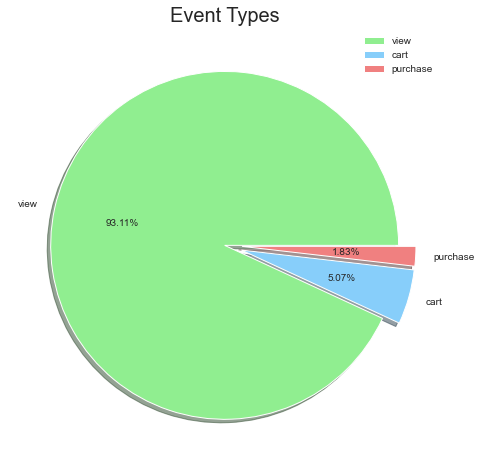

Wall time: 440 ms


In [36]:
%%time
# a piechart showing % of event types
labels = ['view', 'cart', 'purchase']
size = event_type_df['total_events']
colors = ['lightgreen', 'lightskyblue','lightcoral']
explode = [0, 0.1, 0.1]

plt.rcParams['figure.figsize'] = (16, 8)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Event Types', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

## Customer-Level

### Purchasing Power

In [37]:
# how many customers have bought more than one item?
sql04 = """
        WITH 
        user AS 
            (
            SELECT  
            user_id
            , SUM(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END) AS purchase_total

            FROM `iod-capstone.ecommerce_events.events_2020_Q1`
            GROUP BY user_id
            )

        SELECT 
        CASE WHEN purchase_total = 0 THEN 'no_purchase' 
             WHEN purchase_total = 1 THEN 'one_purchase'
             WHEN purchase_total > 1 THEN 'more_purchase' END AS customer_purchase
        ,COUNT(DISTINCT user_id) as total_users
        FROM user
        GROUP BY customer_purchase
        """

In [38]:
customer_purchase_df = bigquery_to_dataframe(sql04)

In [39]:
customer_purchase_df.head()

,customer_purchase,total_users
0,no_purchase,7988115
1,one_purchase,480644
2,more_purchase,493507


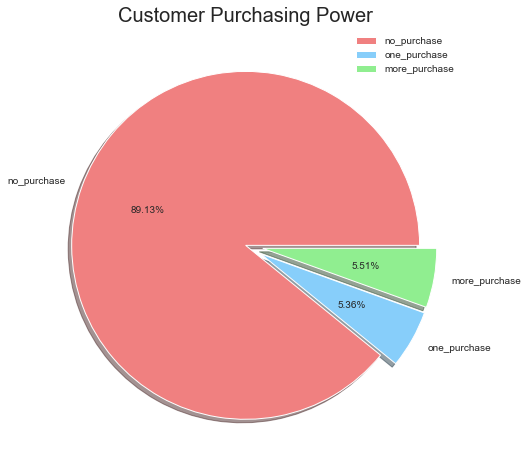

In [40]:
# a piechart showing % of customer purchase types
labels = ['no_purchase', 'one_purchase', 'more_purchase']
size = customer_purchase_df['total_users']
colors = ['lightcoral', 'lightskyblue', 'lightgreen']
explode = [0, 0.1, 0.1]

plt.rcParams['figure.figsize'] = (16, 8)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Customer Purchasing Power', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

# Customer RFM DataFrame

For the purpose of this project, we will only scope our focus on **'repeat'** customers - i.e. customers who have more than one purchasing days.

That means only if a customer has bought items on more than one day, not only more than one item.

Based on the RFM framework, the features we will use for modelling are `days_from_last_purchase` (Recency), `purchase_total` (Frequency), `purchase_amount_total` (Monetary).

## Feature Engineering

The below query is saved as a new table: `iod-capstone.ecommerce_users.user_rfm` and we will fetch it below.

    SELECT 
            user_id
           ,days_from_last_purchase
           ,purchase_total
           ,purchase_amount_total
           ,CASE WHEN num_purchase_days = 0 THEN 'never' 
                 WHEN num_purchase_days = 1 THEN 'one_timer'
                 WHEN num_purchase_days > 1 THEN 'repeat' END AS customer_purchase_type

    FROM (
        SELECT  
        user_id

        --Recency (last day of data is 2020-03-31)
        , DATE_DIFF(DATE('2020-03-31'), MAX(CASE WHEN event_type = 'purchase' THEN DATE(event_time) ELSE NULL END), DAY)  AS days_from_last_purchase
        , COUNT(DISTINCT(CASE WHEN event_type = 'purchase' THEN DATE(event_time) ELSE NULL END))                          AS num_purchase_days

        --Frequency
        , SUM(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END) AS purchase_total

        --Monetary
        , SUM(CASE WHEN event_type = 'purchase' THEN price ELSE 0 END) AS purchase_amount_total

        FROM `iod-capstone.ecommerce_events.events_2020_Q1`
        GROUP BY user_id) 

In [74]:
# filtering only repeat customers
sql05 = """
        SELECT
         user_id
        ,days_from_last_purchase
        ,purchase_total
        ,purchase_amount_total
        FROM `iod-capstone.ecommerce_users.user_rfm` 
        WHERE customer_purchase_type = 'repeat'
        """

In [75]:
customer_df = bigquery_to_dataframe(sql05)

In [76]:
customer_df.head(10)

,user_id,days_from_last_purchase,purchase_total,purchase_amount_total
0,515947667,85,2,1174.18
1,546464554,77,4,649.79
2,587615207,75,3,980.47
3,582417846,86,2,3265.96
4,556605306,83,3,800.01
5,550951160,81,2,1981.00
6,538240613,83,6,259.81
7,583147567,78,4,410.47
8,557652649,84,3,232.96
9,536037136,82,2,198.11


In [77]:
# total number of repeat customers
customer_df.shape

(338758, 4)

In [78]:
# checking null values
customer_df.isna().sum()

user_id                    0
days_from_last_purchase    0
purchase_total             0
purchase_amount_total      0
dtype: int64

In [79]:
# saving dataframe into parquet file to be exported into local (just in case)
customer_df.to_parquet("C:\\Users\\sakina.sakdun\\Documents\\GitHub\\IOD\\Projects\\capstone\\customer_rfm_base.parquet.gzip", compression='gzip') 

In [80]:
# reading parquet file (this file is saved in "output folder")
customer_df = pd.read_parquet("C:\\Users\\sakina.sakdun\\Documents\\GitHub\\IOD\\Projects\\capstone\\customer_rfm_base.parquet.gzip")

In [81]:
# set id as index
rfm_df = customer_df.set_index('user_id')

In [82]:
rfm_df.head()  # this will be our main dataframe

,days_from_last_purchase,purchase_total,purchase_amount_total
user_id,,,
515947667,85,2,1174.18
546464554,77,4,649.79
587615207,75,3,980.47
582417846,86,2,3265.96
556605306,83,3,800.01


## EDA (Processed Data)

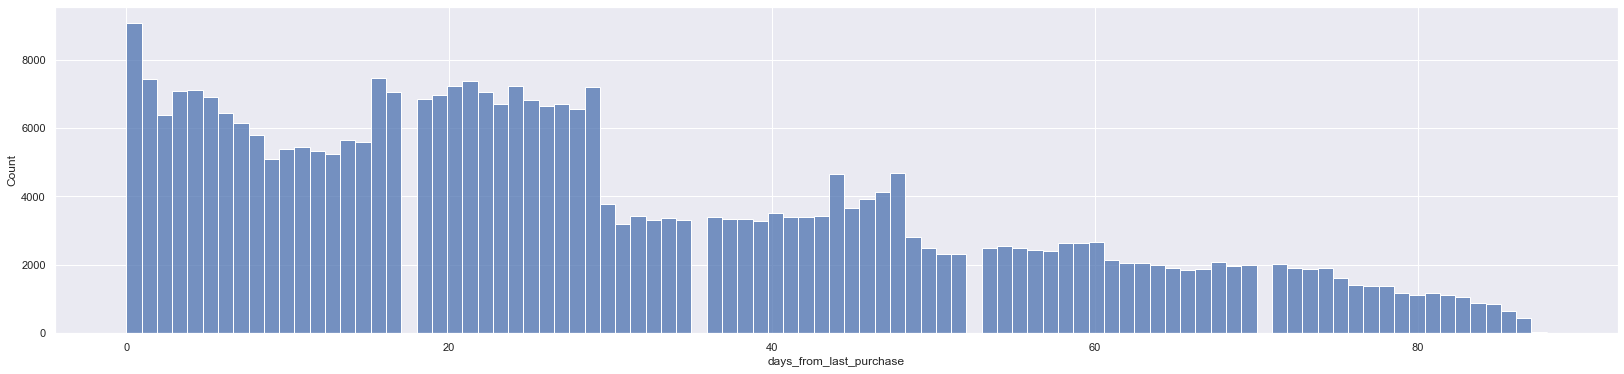

In [83]:
# Recency
sns.set(rc={'figure.figsize':(28,6)})
sns.histplot(rfm_df['days_from_last_purchase']);

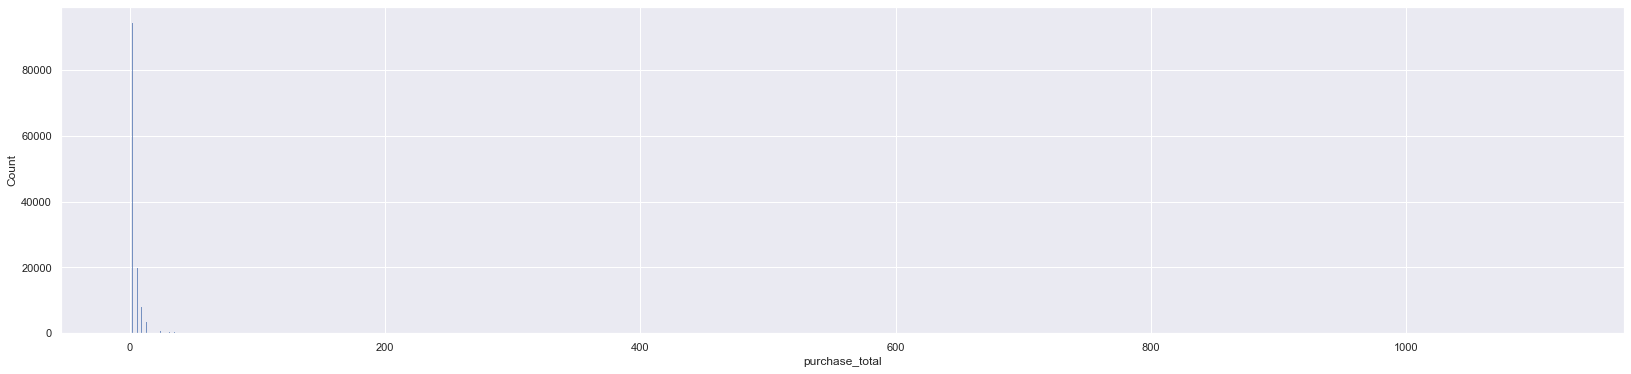

In [84]:
# Frequency - extremely skewed to the right
sns.set(rc={'figure.figsize':(28,6)})
sns.histplot(rfm_df['purchase_total']);

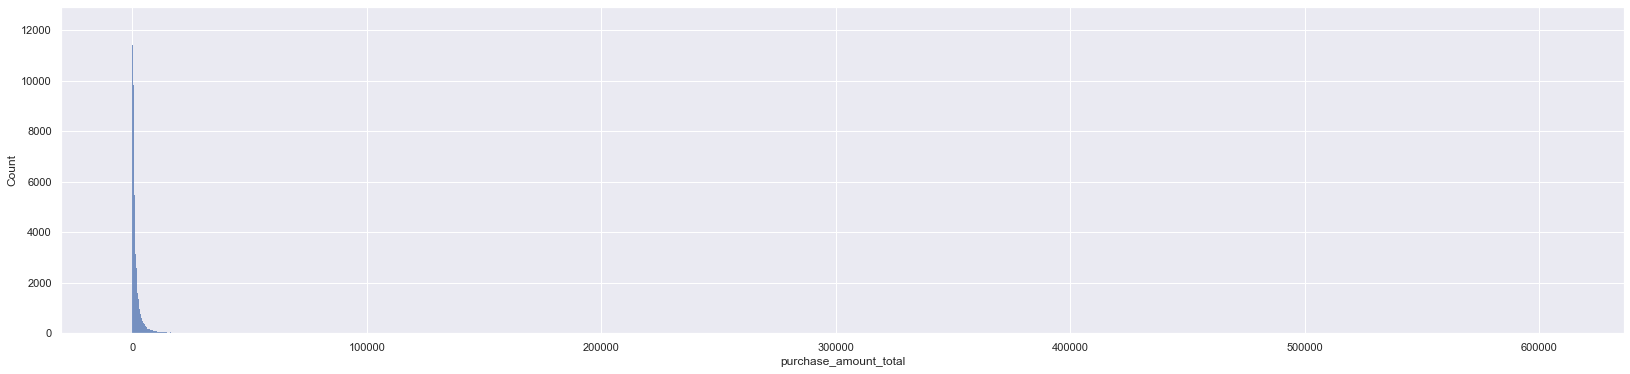

In [85]:
# Monetary - extremely skewed to the right
sns.set(rc={'figure.figsize':(28,6)})
sns.histplot(rfm_df['purchase_amount_total']);

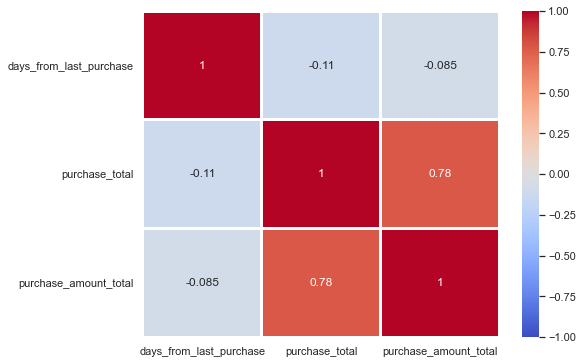

In [86]:
# correlation heatmap
sns.set(rc={'figure.figsize':(8,6)})
sns.heatmap(rfm_df.corr(), annot = True, fmt='.2g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=2, linecolor='white')   # annot=annotation, fmt=decimal points shown
plt.show()

In [87]:
# distribution
rfm_df.describe(percentiles=[.1, .25, .5, .75, .9, .99, .995, .999])

,days_from_last_purchase,purchase_total,purchase_amount_total
count,338758.000000,338758.000000,338758.000000
mean,30.232733,6.474587,2105.179136
std,22.064663,12.189830,5722.165379
min,0.000000,2.000000,2.320000
10%,4.000000,2.000000,169.800000
25%,13.000000,2.000000,370.600000
50%,25.000000,4.000000,849.030000
75%,46.000000,6.000000,2023.457500
90%,64.000000,12.000000,4488.022000
99%,83.000000,50.000000,20059.847400


## Log Transformation

Log Transform helps to handle skewed data and after transformation, the distribution becomes more approximate to normal

In [88]:
rfm_df['recency_log'] = (rfm_df['days_from_last_purchase']+1).transform(np.log)

In [89]:
rfm_df['frequency_log'] = rfm_df['purchase_total'].transform(np.log)

In [90]:
rfm_df['monetary_log'] = rfm_df['purchase_amount_total'].transform(np.log)

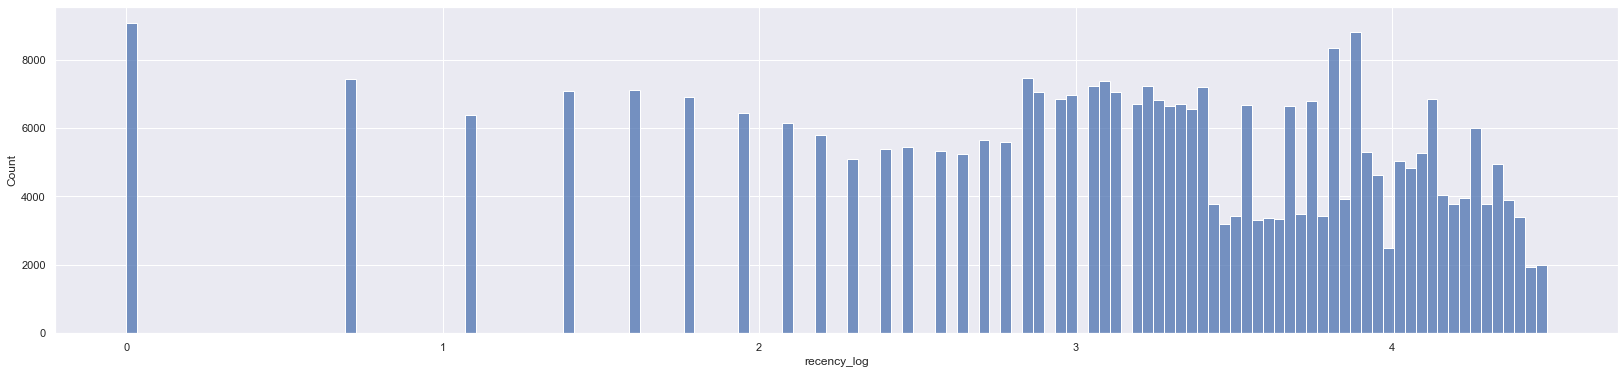

In [116]:
# Recency
sns.set(rc={'figure.figsize':(28,6)})
sns.histplot(rfm_df['recency_log']);

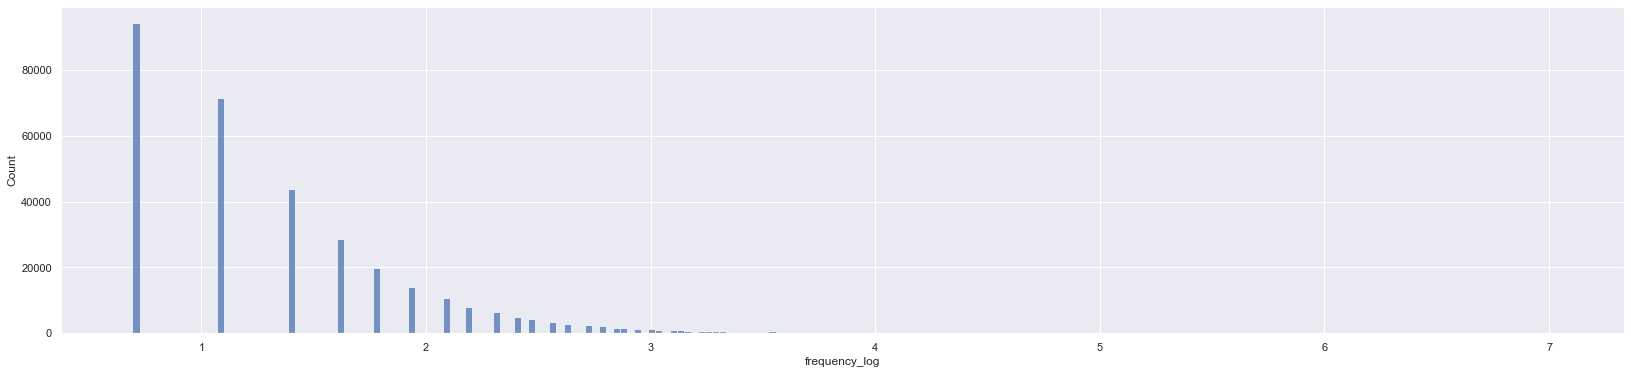

In [117]:
# Frequency - extremely skewed to the right
sns.set(rc={'figure.figsize':(28,6)})
sns.histplot(rfm_df['frequency_log']);

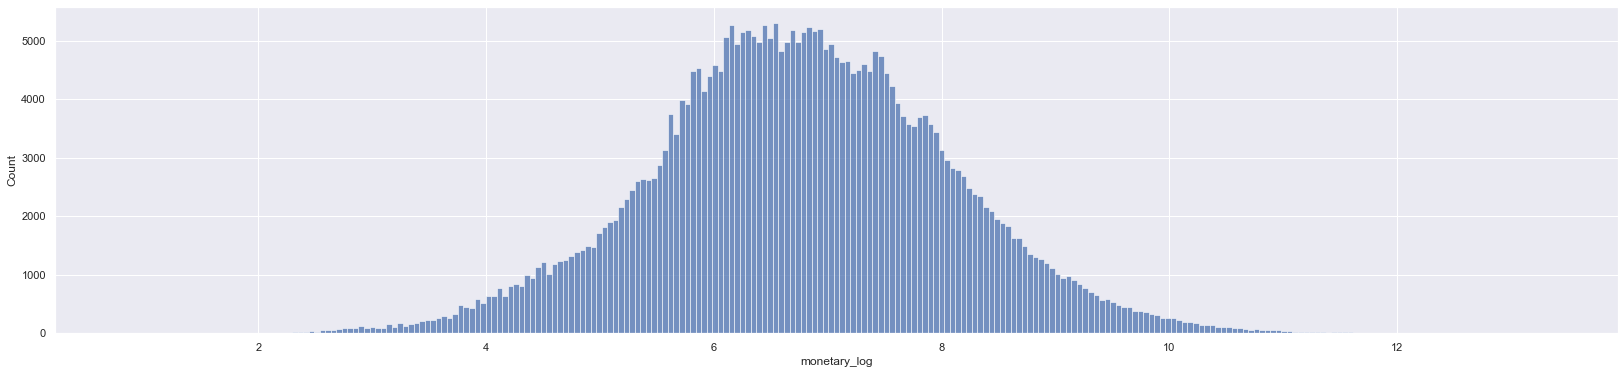

In [120]:
# Monetary - extremely skewed to the right
sns.set(rc={'figure.figsize':(28,6)})
sns.histplot(rfm_df['monetary_log']);

In [91]:
# after log transformation
rfm_df.describe(percentiles=[.1, .25, .5, .75, .9, .99, .995, .999])

,days_from_last_purchase,purchase_total,purchase_amount_total,recency_log,frequency_log,monetary_log
count,338758.000000,338758.000000,338758.000000,338758.000000,338758.000000,338758.000000
mean,30.232733,6.474587,2105.179136,3.074476,1.452108,6.760662
std,22.064663,12.189830,5722.165379,1.014545,0.757986,1.303781
min,0.000000,2.000000,2.320000,0.000000,0.693147,0.841567
10%,4.000000,2.000000,169.800000,1.609438,0.693147,5.134621
25%,13.000000,2.000000,370.600000,2.639057,0.693147,5.915123
50%,25.000000,4.000000,849.030000,3.258097,1.386294,6.744095
75%,46.000000,6.000000,2023.457500,3.850148,1.791759,7.612563
90%,64.000000,12.000000,4488.022000,4.174387,2.484907,8.409167
99%,83.000000,50.000000,20059.847400,4.430817,3.912023,9.906475


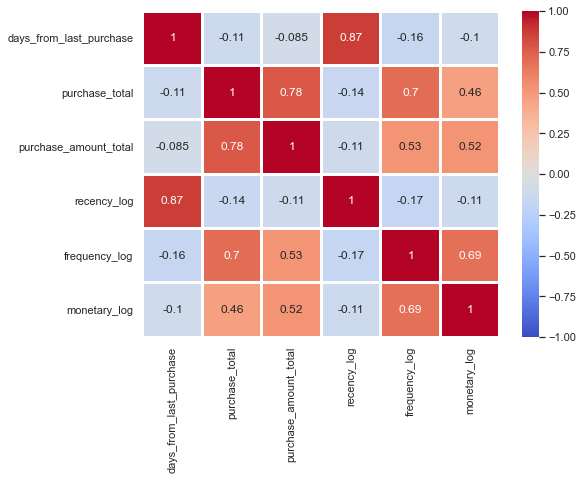

In [96]:
# correlation heatmap
sns.set(rc={'figure.figsize':(8,6)})
sns.heatmap(rfm_df.corr(), annot = True, fmt='.2g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=2, linecolor='white')   # annot=annotation, fmt=decimal points shown
plt.show()

In [92]:
# saving dataframe into parquet file to be exported into local (just in case)
rfm_df.to_parquet("C:\\Users\\sakina.sakdun\\Documents\\GitHub\\IOD\\Projects\\capstone\\rfm_log.parquet.gzip", compression='gzip') 

In [93]:
# reading parquet file
rfm_df = pd.read_parquet("C:\\Users\\sakina.sakdun\\Documents\\GitHub\\IOD\\Projects\\capstone\\rfm_log.parquet.gzip")

In [102]:
# for saving all cluster labels
output_df = rfm_df

# RFM Manual Calculation

The simplest way to create customers segments from RFM Model is to use Quartiles. We assign a score from 1 to 4 to Recency, Frequency and Monetary. 

Four is the best/highest value, and one is the lowest/worst value. A final RFM score is calculated simply by combining individual RFM score numbers.

In [94]:
# taking the original values
manual_rfm_df = rfm_df[['days_from_last_purchase', 'purchase_total', 'purchase_amount_total']]

In [95]:
manual_rfm_df.head()

,days_from_last_purchase,purchase_total,purchase_amount_total
user_id,,,
515947667,85,2,1174.18
546464554,77,4,649.79
587615207,75,3,980.47
582417846,86,2,3265.96
556605306,83,3,800.01


In [97]:
# rename columns
manual_rfm_df = manual_rfm_df.rename(columns={"days_from_last_purchase": "recency", "purchase_total": "frequency", "purchase_amount_total": "monetary" })
manual_rfm_df.head()

,recency,frequency,monetary
user_id,,,
515947667,85,2,1174.18
546464554,77,4,649.79
587615207,75,3,980.47
582417846,86,2,3265.96
556605306,83,3,800.01


In [98]:
manual_rfm_df.isna().sum()

recency      0
frequency    0
monetary     0
dtype: int64

RFM Quantiles

In [99]:
quantiles = manual_rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles

,recency,frequency,monetary
0.25,13.0,2.0,370.6000
0.50,25.0,4.0,849.0300
0.75,46.0,6.0,2023.4575


In [100]:
quantiles.to_dict()

{'recency': {0.25: 13.0, 0.5: 25.0, 0.75: 46.0},
 'frequency': {0.25: 2.0, 0.5: 4.0, 0.75: 6.0},
 'monetary': {0.25: 370.6, 0.5: 849.03, 0.75: 2023.4575}}

In [101]:
## for recency - the higher the number, the worse it is --> highest percentile is 1
# Arguments (x = value, p = recency, monetary, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
## for f and m - the higher the number, the best it is --> highest percentile is 4
# Arguments (x = value, p = recency, monetary, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [103]:
#create rfm segmentation table
manual_rfm_df['R_Quartile'] = manual_rfm_df['recency'].apply(RScore, args=('recency',quantiles,))
manual_rfm_df['F_Quartile'] = manual_rfm_df['frequency'].apply(FMScore, args=('frequency',quantiles,))
manual_rfm_df['M_Quartile'] = manual_rfm_df['monetary'].apply(FMScore, args=('monetary',quantiles,))

In [104]:
manual_rfm_df.head()

,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile
user_id,,,,,,
515947667,85,2,1174.18,1,1,3
546464554,77,4,649.79,1,2,2
587615207,75,3,980.47,1,2,3
582417846,86,2,3265.96,1,1,4
556605306,83,3,800.01,1,2,2


In [105]:
# combine the RFM values
manual_rfm_df['RFMScore'] = manual_rfm_df.R_Quartile.map(str) \
                            + manual_rfm_df.F_Quartile.map(str) \
                            + manual_rfm_df.M_Quartile.map(str)
manual_rfm_df.head()

,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
user_id,,,,,,,
515947667,85,2,1174.18,1,1,3,113
546464554,77,4,649.79,1,2,2,122
587615207,75,3,980.47,1,2,3,123
582417846,86,2,3265.96,1,1,4,114
556605306,83,3,800.01,1,2,2,122


In [106]:
# best customers
manual_rfm_df[manual_rfm_df['RFMScore']=='444'].sort_values('monetary', ascending=False).head(10)

,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
user_id,,,,,,,
595104624,5,458,605792.74,4,4,4,444
610871788,0,368,546212.90,4,4,4,444
598224683,0,959,499776.17,4,4,4,444
549109608,3,758,392266.22,4,4,4,444
513230794,9,824,392139.44,4,4,4,444
562104312,11,229,313069.00,4,4,4,444
513320236,0,620,312964.70,4,4,4,444
569333570,0,225,305436.36,4,4,4,444
582007259,0,233,285394.16,4,4,4,444


## Cluster Results

In [109]:
# example results
print('Loyal Customers: ',len(manual_rfm_df[manual_rfm_df['F_Quartile']==4]))
print("Big Spenders: ",len(manual_rfm_df[manual_rfm_df['M_Quartile']==4]))
print("Recent Customers: ",len(manual_rfm_df[manual_rfm_df['R_Quartile']==1]))

print("High Value, Low Risk: ",len(manual_rfm_df[manual_rfm_df['RFMScore']=='444']))
print('High Value, Mid Risk: ', len(manual_rfm_df[manual_rfm_df['RFMScore']=='244']))
print('High Value, High Risk: ',len(manual_rfm_df[manual_rfm_df['RFMScore']=='144']))

print('Low Value, High Risk: ',len(manual_rfm_df[manual_rfm_df['RFMScore']=='111']))
print('Low Value, Low Risk: ',len(manual_rfm_df[manual_rfm_df['RFMScore']=='431']))
print('Low Value, Mid Risk: ',len(manual_rfm_df[manual_rfm_df['RFMScore']=='231']))

Loyal Customers:  80409
Big Spenders:  84690
Recent Customers:  81022
High Value, Low Risk:  19941
High Value, Mid Risk:  12944
High Value, High Risk:  7963
Low Value, High Risk:  14351
Low Value, Low Risk:  1402
Low Value, Mid Risk:  1514


In [110]:
manual_groups = manual_rfm_df.groupby('RFMScore').size()

In [111]:
# total combinations of RFMScores - 64 groups
len(manual_groups) 

64

In [112]:
# number of customers in each group
manual_groups[:21]

RFMScore
111    14351
112     8300
113     5142
114      904
121     6902
122    10726
123     7801
124     4012
131      974
132     2387
133     3997
134     2922
141      288
142      829
143     3524
144     7963
211    11011
212     5653
213     3372
214      640
221     8439
dtype: int64

In [113]:
manual_groups[21:44]

RFMScore
222    11397
223     8395
224     4200
231     1514
232     3158
233     5084
234     3763
241      591
242     1369
243     5291
244    12944
311    12451
312     6687
313     3878
314      701
321     7326
322     9465
323     6986
324     3407
331     1343
332     2853
333     4402
334     3209
dtype: int64

In [114]:
manual_groups[44:]

RFMScore
341      489
342     1374
343     4660
344    12780
411    10438
412     6726
413     3500
414      601
421     6562
422     9068
423     7549
424     3164
431     1402
432     2976
433     5072
434     3539
441      610
442     1721
443     6035
444    19941
dtype: int64

In [115]:
# saving dataframe into parquet file to be exported into local (just in case)
manual_rfm_df.to_parquet("C:\\Users\\sakina.sakdun\\Documents\\GitHub\\IOD\\Projects\\capstone\\manual_rfm_group.parquet.gzip", compression='gzip') 

From above, they are so many and hard to judge which belongs together with which.. 

But first let's compare it with unsupervised clustering

# RFM Machine Learning

## Features

In [152]:
# taking log-transformed features
X_rfm_df = rfm_df[['recency_log', 'frequency_log', 'monetary_log']]

In [153]:
X_rfm_df.shape

(338758, 3)

In [154]:
X_rfm_df.head()

,recency_log,frequency_log,monetary_log
user_id,,,
515947667,4.454347,0.693147,7.068325
546464554,4.356709,1.386294,6.476649
587615207,4.330733,1.098612,6.888032
582417846,4.465908,0.693147,8.091309
556605306,4.430817,1.098612,6.684624


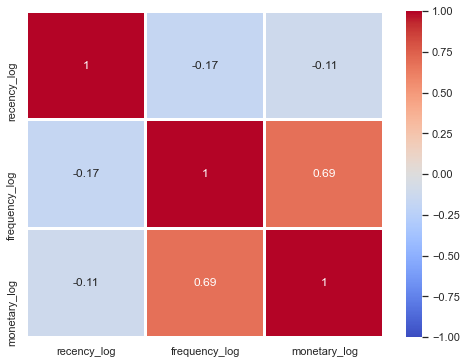

In [155]:
sns.set(rc={'figure.figsize':(8,6)})
sns.heatmap(X_rfm_df.corr(), annot = True, fmt='.2g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=2, linecolor='white')   # annot=annotation, fmt=decimal points shown
plt.show()

## Mini Batch KMeans

In [194]:
X_rfm_df.head()

,recency_log,frequency_log,monetary_log
user_id,,,
515947667,4.454347,0.693147,7.068325
546464554,4.356709,1.386294,6.476649
587615207,4.330733,1.098612,6.888032
582417846,4.465908,0.693147,8.091309
556605306,4.430817,1.098612,6.684624


In [192]:
%%time
## Getting optimal K for our model
inertias = []

# for k clusters 
K = range(1, 15)

for k in K:
    # Building and fitting the model
    mbk = MiniBatchKMeans(n_clusters=k, verbose=1, random_state=124).fit(X_rfm_df)
    # append the inertia into a list
    inertias.append(mbk.inertia_)

Init 1/3 with method: k-means++
Inertia for init 1/3: 914.886536
Init 2/3 with method: k-means++
Inertia for init 2/3: 914.886536
Init 3/3 with method: k-means++
Inertia for init 3/3: 914.886536
Minibatch iteration 1/338800: mean batch inertia: 3.105956, ewa inertia: 3.105956 
Minibatch iteration 2/338800: mean batch inertia: 3.362859, ewa inertia: 3.106108 
Minibatch iteration 3/338800: mean batch inertia: 3.493216, ewa inertia: 3.106336 
Minibatch iteration 4/338800: mean batch inertia: 3.494969, ewa inertia: 3.106566 
Minibatch iteration 5/338800: mean batch inertia: 3.084551, ewa inertia: 3.106553 
Minibatch iteration 6/338800: mean batch inertia: 3.224024, ewa inertia: 3.106622 
Minibatch iteration 7/338800: mean batch inertia: 3.685423, ewa inertia: 3.106964 
Minibatch iteration 8/338800: mean batch inertia: 3.285939, ewa inertia: 3.107070 
Minibatch iteration 9/338800: mean batch inertia: 3.340566, ewa inertia: 3.107207 
Minibatch iteration 10/338800: mean batch inertia: 3.54450

Minibatch iteration 201/338800: mean batch inertia: 0.912923, ewa inertia: 1.038308 
Minibatch iteration 202/338800: mean batch inertia: 0.929357, ewa inertia: 1.038244 
Minibatch iteration 203/338800: mean batch inertia: 0.791661, ewa inertia: 1.038098 
Minibatch iteration 204/338800: mean batch inertia: 0.723555, ewa inertia: 1.037913 
Minibatch iteration 205/338800: mean batch inertia: 0.879484, ewa inertia: 1.037819 
Minibatch iteration 206/338800: mean batch inertia: 0.811037, ewa inertia: 1.037685 
Minibatch iteration 207/338800: mean batch inertia: 1.007712, ewa inertia: 1.037668 
Minibatch iteration 208/338800: mean batch inertia: 0.863829, ewa inertia: 1.037565 
Minibatch iteration 209/338800: mean batch inertia: 0.903440, ewa inertia: 1.037486 
Minibatch iteration 210/338800: mean batch inertia: 0.906749, ewa inertia: 1.037409 
Minibatch iteration 211/338800: mean batch inertia: 0.809494, ewa inertia: 1.037274 
Minibatch iteration 212/338800: mean batch inertia: 0.927664, ewa

Minibatch iteration 355/338800: mean batch inertia: 1.049767, ewa inertia: 1.028435 
Minibatch iteration 356/338800: mean batch inertia: 1.058138, ewa inertia: 1.028453 
Minibatch iteration 357/338800: mean batch inertia: 0.999904, ewa inertia: 1.028436 
Minibatch iteration 358/338800: mean batch inertia: 0.898328, ewa inertia: 1.028359 
Minibatch iteration 359/338800: mean batch inertia: 1.102143, ewa inertia: 1.028403 
Minibatch iteration 360/338800: mean batch inertia: 1.039959, ewa inertia: 1.028410 
Minibatch iteration 361/338800: mean batch inertia: 0.949742, ewa inertia: 1.028363 
Minibatch iteration 362/338800: mean batch inertia: 0.972349, ewa inertia: 1.028330 
Minibatch iteration 363/338800: mean batch inertia: 0.818490, ewa inertia: 1.028206 
Minibatch iteration 364/338800: mean batch inertia: 0.891020, ewa inertia: 1.028125 
Minibatch iteration 365/338800: mean batch inertia: 0.986115, ewa inertia: 1.028101 
Minibatch iteration 366/338800: mean batch inertia: 0.929015, ewa

Minibatch iteration 498/338800: mean batch inertia: 0.858876, ewa inertia: 1.019481 
Minibatch iteration 499/338800: mean batch inertia: 0.865962, ewa inertia: 1.019391 
Minibatch iteration 500/338800: mean batch inertia: 0.953710, ewa inertia: 1.019352 
Minibatch iteration 501/338800: mean batch inertia: 0.955705, ewa inertia: 1.019314 
Minibatch iteration 502/338800: mean batch inertia: 1.153034, ewa inertia: 1.019393 
Minibatch iteration 503/338800: mean batch inertia: 0.926363, ewa inertia: 1.019338 
Minibatch iteration 504/338800: mean batch inertia: 0.958235, ewa inertia: 1.019302 
Minibatch iteration 505/338800: mean batch inertia: 1.078722, ewa inertia: 1.019337 
Minibatch iteration 506/338800: mean batch inertia: 0.852640, ewa inertia: 1.019239 
Minibatch iteration 507/338800: mean batch inertia: 1.034220, ewa inertia: 1.019248 
Minibatch iteration 508/338800: mean batch inertia: 1.046928, ewa inertia: 1.019264 
Minibatch iteration 509/338800: mean batch inertia: 0.892047, ewa

Minibatch iteration 694/338800: mean batch inertia: 0.749198, ewa inertia: 1.008422 
Minibatch iteration 695/338800: mean batch inertia: 1.067968, ewa inertia: 1.008457 
Minibatch iteration 696/338800: mean batch inertia: 0.766619, ewa inertia: 1.008314 
Minibatch iteration 697/338800: mean batch inertia: 0.927546, ewa inertia: 1.008267 
Minibatch iteration 698/338800: mean batch inertia: 0.927324, ewa inertia: 1.008219 
Minibatch iteration 699/338800: mean batch inertia: 0.991266, ewa inertia: 1.008209 
Minibatch iteration 700/338800: mean batch inertia: 1.044341, ewa inertia: 1.008230 
Minibatch iteration 701/338800: mean batch inertia: 0.865915, ewa inertia: 1.008146 
Minibatch iteration 702/338800: mean batch inertia: 0.880436, ewa inertia: 1.008071 
Minibatch iteration 703/338800: mean batch inertia: 1.014207, ewa inertia: 1.008074 
Minibatch iteration 704/338800: mean batch inertia: 1.007909, ewa inertia: 1.008074 
Minibatch iteration 705/338800: mean batch inertia: 0.839198, ewa

Init 1/3 with method: k-means++
Inertia for init 1/3: 267.304268
Init 2/3 with method: k-means++
Inertia for init 2/3: 258.030070
Init 3/3 with method: k-means++
Inertia for init 3/3: 244.589761
Minibatch iteration 1/338800: mean batch inertia: 0.862402, ewa inertia: 0.862402 
Minibatch iteration 2/338800: mean batch inertia: 0.795348, ewa inertia: 0.862363 
Minibatch iteration 3/338800: mean batch inertia: 0.984053, ewa inertia: 0.862434 
Minibatch iteration 4/338800: mean batch inertia: 0.982828, ewa inertia: 0.862506 
Minibatch iteration 5/338800: mean batch inertia: 0.911438, ewa inertia: 0.862534 
Minibatch iteration 6/338800: mean batch inertia: 0.827603, ewa inertia: 0.862514 
Minibatch iteration 7/338800: mean batch inertia: 0.844639, ewa inertia: 0.862503 
Minibatch iteration 8/338800: mean batch inertia: 0.902652, ewa inertia: 0.862527 
Minibatch iteration 9/338800: mean batch inertia: 0.898441, ewa inertia: 0.862548 
Minibatch iteration 10/338800: mean batch inertia: 0.68241

Init 1/3 with method: k-means++
Inertia for init 1/3: 177.506745
Init 2/3 with method: k-means++
Inertia for init 2/3: 193.199535
Init 3/3 with method: k-means++
Inertia for init 3/3: 182.749425
Minibatch iteration 1/338800: mean batch inertia: 0.611598, ewa inertia: 0.611598 
Minibatch iteration 2/338800: mean batch inertia: 0.728551, ewa inertia: 0.611667 
Minibatch iteration 3/338800: mean batch inertia: 0.693085, ewa inertia: 0.611715 
Minibatch iteration 4/338800: mean batch inertia: 0.645126, ewa inertia: 0.611735 
Minibatch iteration 5/338800: mean batch inertia: 0.587803, ewa inertia: 0.611721 
Minibatch iteration 6/338800: mean batch inertia: 0.699343, ewa inertia: 0.611773 
Minibatch iteration 7/338800: mean batch inertia: 0.837588, ewa inertia: 0.611906 
Minibatch iteration 8/338800: mean batch inertia: 0.593875, ewa inertia: 0.611895 
Minibatch iteration 9/338800: mean batch inertia: 0.667764, ewa inertia: 0.611928 
Minibatch iteration 10/338800: mean batch inertia: 0.64378

Init 1/3 with method: k-means++
Inertia for init 1/3: 148.647158
Init 2/3 with method: k-means++
Inertia for init 2/3: 154.469807
Init 3/3 with method: k-means++
Inertia for init 3/3: 148.887257
Minibatch iteration 1/338800: mean batch inertia: 0.588527, ewa inertia: 0.588527 
Minibatch iteration 2/338800: mean batch inertia: 0.597654, ewa inertia: 0.588533 
Minibatch iteration 3/338800: mean batch inertia: 0.555205, ewa inertia: 0.588513 
Minibatch iteration 4/338800: mean batch inertia: 0.564673, ewa inertia: 0.588499 
Minibatch iteration 5/338800: mean batch inertia: 0.559703, ewa inertia: 0.588482 
Minibatch iteration 6/338800: mean batch inertia: 0.555790, ewa inertia: 0.588462 
Minibatch iteration 7/338800: mean batch inertia: 0.535853, ewa inertia: 0.588431 
Minibatch iteration 8/338800: mean batch inertia: 0.592005, ewa inertia: 0.588434 
Minibatch iteration 9/338800: mean batch inertia: 0.512107, ewa inertia: 0.588388 
Minibatch iteration 10/338800: mean batch inertia: 0.50899

Minibatch iteration 215/338800: mean batch inertia: 0.548260, ewa inertia: 0.580930 
Minibatch iteration 216/338800: mean batch inertia: 0.544327, ewa inertia: 0.580908 
Minibatch iteration 217/338800: mean batch inertia: 0.505960, ewa inertia: 0.580864 
Minibatch iteration 218/338800: mean batch inertia: 0.576115, ewa inertia: 0.580861 
Minibatch iteration 219/338800: mean batch inertia: 0.536343, ewa inertia: 0.580835 
Minibatch iteration 220/338800: mean batch inertia: 0.523036, ewa inertia: 0.580801 
Minibatch iteration 221/338800: mean batch inertia: 0.609770, ewa inertia: 0.580818 
Minibatch iteration 222/338800: mean batch inertia: 0.642607, ewa inertia: 0.580854 
Minibatch iteration 223/338800: mean batch inertia: 0.514494, ewa inertia: 0.580815 
Minibatch iteration 224/338800: mean batch inertia: 0.482474, ewa inertia: 0.580757 
Minibatch iteration 225/338800: mean batch inertia: 0.556821, ewa inertia: 0.580743 
Minibatch iteration 226/338800: mean batch inertia: 0.601783, ewa

Minibatch iteration 314/338800: mean batch inertia: 0.548822, ewa inertia: 0.577770 
Minibatch iteration 315/338800: mean batch inertia: 0.489740, ewa inertia: 0.577718 
Minibatch iteration 316/338800: mean batch inertia: 0.529952, ewa inertia: 0.577690 
Minibatch iteration 317/338800: mean batch inertia: 0.521505, ewa inertia: 0.577657 
Minibatch iteration 318/338800: mean batch inertia: 0.551876, ewa inertia: 0.577641 
Minibatch iteration 319/338800: mean batch inertia: 0.530992, ewa inertia: 0.577614 
Minibatch iteration 320/338800: mean batch inertia: 0.475883, ewa inertia: 0.577554 
Minibatch iteration 321/338800: mean batch inertia: 0.528429, ewa inertia: 0.577525 
Minibatch iteration 322/338800: mean batch inertia: 0.717334, ewa inertia: 0.577607 
Minibatch iteration 323/338800: mean batch inertia: 0.501215, ewa inertia: 0.577562 
Minibatch iteration 324/338800: mean batch inertia: 0.492592, ewa inertia: 0.577512 
Minibatch iteration 325/338800: mean batch inertia: 0.512382, ewa

Minibatch iteration 443/338800: mean batch inertia: 0.442276, ewa inertia: 0.573888 
Minibatch iteration 444/338800: mean batch inertia: 0.574638, ewa inertia: 0.573889 
Minibatch iteration 445/338800: mean batch inertia: 0.472499, ewa inertia: 0.573829 
Minibatch iteration 446/338800: mean batch inertia: 0.556460, ewa inertia: 0.573819 
Minibatch iteration 447/338800: mean batch inertia: 0.532089, ewa inertia: 0.573794 
Minibatch iteration 448/338800: mean batch inertia: 0.428181, ewa inertia: 0.573708 
Minibatch iteration 449/338800: mean batch inertia: 0.533148, ewa inertia: 0.573684 
Minibatch iteration 450/338800: mean batch inertia: 0.512878, ewa inertia: 0.573648 
Minibatch iteration 451/338800: mean batch inertia: 0.467911, ewa inertia: 0.573586 
Minibatch iteration 452/338800: mean batch inertia: 0.451572, ewa inertia: 0.573514 
Minibatch iteration 453/338800: mean batch inertia: 0.479325, ewa inertia: 0.573458 
Minibatch iteration 454/338800: mean batch inertia: 0.503044, ewa

Minibatch iteration 554/338800: mean batch inertia: 0.497725, ewa inertia: 0.570768 
Minibatch iteration 555/338800: mean batch inertia: 0.514501, ewa inertia: 0.570734 
Minibatch iteration 556/338800: mean batch inertia: 0.473375, ewa inertia: 0.570677 
Minibatch iteration 557/338800: mean batch inertia: 0.460084, ewa inertia: 0.570612 
Minibatch iteration 558/338800: mean batch inertia: 0.500855, ewa inertia: 0.570570 
Minibatch iteration 559/338800: mean batch inertia: 0.528540, ewa inertia: 0.570546 
Minibatch iteration 560/338800: mean batch inertia: 0.483100, ewa inertia: 0.570494 
Minibatch iteration 561/338800: mean batch inertia: 0.570871, ewa inertia: 0.570494 
Minibatch iteration 562/338800: mean batch inertia: 0.513639, ewa inertia: 0.570461 
Minibatch iteration 563/338800: mean batch inertia: 0.464222, ewa inertia: 0.570398 
Minibatch iteration 564/338800: mean batch inertia: 0.516997, ewa inertia: 0.570366 
Minibatch iteration 565/338800: mean batch inertia: 0.548907, ewa

Minibatch iteration 654/338800: mean batch inertia: 0.462115, ewa inertia: 0.567472 
Minibatch iteration 655/338800: mean batch inertia: 0.511167, ewa inertia: 0.567439 
Minibatch iteration 656/338800: mean batch inertia: 0.492641, ewa inertia: 0.567395 
Minibatch iteration 657/338800: mean batch inertia: 0.518453, ewa inertia: 0.567366 
Minibatch iteration 658/338800: mean batch inertia: 0.521693, ewa inertia: 0.567339 
Minibatch iteration 659/338800: mean batch inertia: 0.513432, ewa inertia: 0.567307 
Minibatch iteration 660/338800: mean batch inertia: 0.539459, ewa inertia: 0.567291 
Minibatch iteration 661/338800: mean batch inertia: 0.532777, ewa inertia: 0.567270 
Minibatch iteration 662/338800: mean batch inertia: 0.574786, ewa inertia: 0.567275 
Minibatch iteration 663/338800: mean batch inertia: 0.553527, ewa inertia: 0.567267 
Minibatch iteration 664/338800: mean batch inertia: 0.417313, ewa inertia: 0.567178 
Minibatch iteration 665/338800: mean batch inertia: 0.567116, ewa

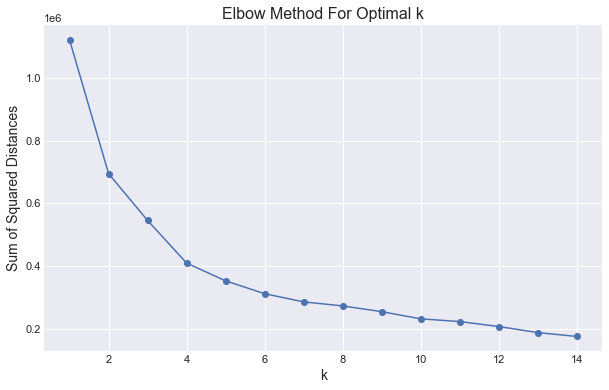

In [193]:
## Plotting the elbow: 
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10, 6))
# Plotting k against Sum of Squared Distances
plt.plot(K, inertias, '-o')
plt.xlabel('k', fontsize=14)
plt.ylabel('Sum of Squared Distances', fontsize=14)
plt.title('Elbow Method For Optimal k', fontsize=16)
plt.show()

# ideal is 7 clusters

In [195]:
%%time
# Our MiniBatchKMeans model
mbk = MiniBatchKMeans(n_clusters=7, random_state=124)
mbk.fit(X_rfm_df)

Wall time: 1.26 s


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=7, n_init=3, random_state=124,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [196]:
# We use the model to predict the respective clusters
cluster_labels = mbk.predict(X_rfm_df)

In [134]:
# # duplicating from original feature dataframe - one for plotting, one for saved output
# X_rfm_output =  X_rfm_df
# X_rfm_plot =  X_rfm_df

In [197]:
X_rfm_output['cluster_labels'] = cluster_labels
X_rfm_plot['cluster_labels'] = cluster_labels

C:\Users\sakina.sakdun\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [201]:
X_rfm_output.head()

,recency_log,frequency_log,monetary_log,cluster_labels
user_id,,,,
515947667,4.454347,0.693147,7.068325,0
546464554,4.356709,1.386294,6.476649,0
587615207,4.330733,1.098612,6.888032,0
582417846,4.465908,0.693147,8.091309,2
556605306,4.430817,1.098612,6.684624,0


In [199]:
X_rfm_plot.head()

,recency_log,frequency_log,monetary_log,cluster_labels
user_id,,,,
515947667,4.454347,0.693147,7.068325,0
546464554,4.356709,1.386294,6.476649,0
587615207,4.330733,1.098612,6.888032,0
582417846,4.465908,0.693147,8.091309,2
556605306,4.430817,1.098612,6.684624,0


### Cluster Results

Wall time: 1min 20s


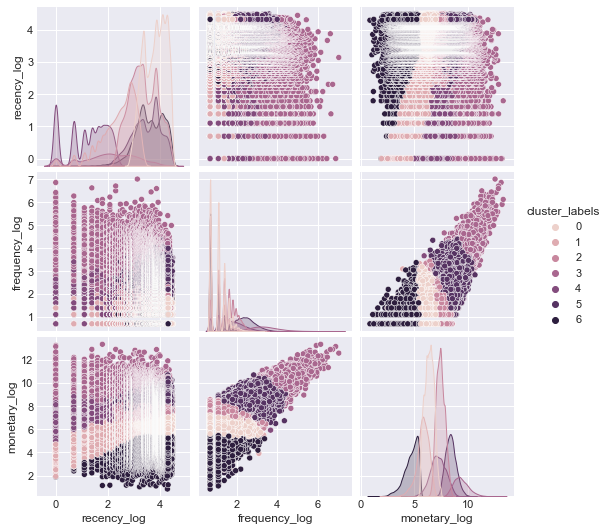

In [202]:
%%time
# let's see how the clustering performed
sns.pairplot(X_rfm_plot, hue = 'cluster_labels')

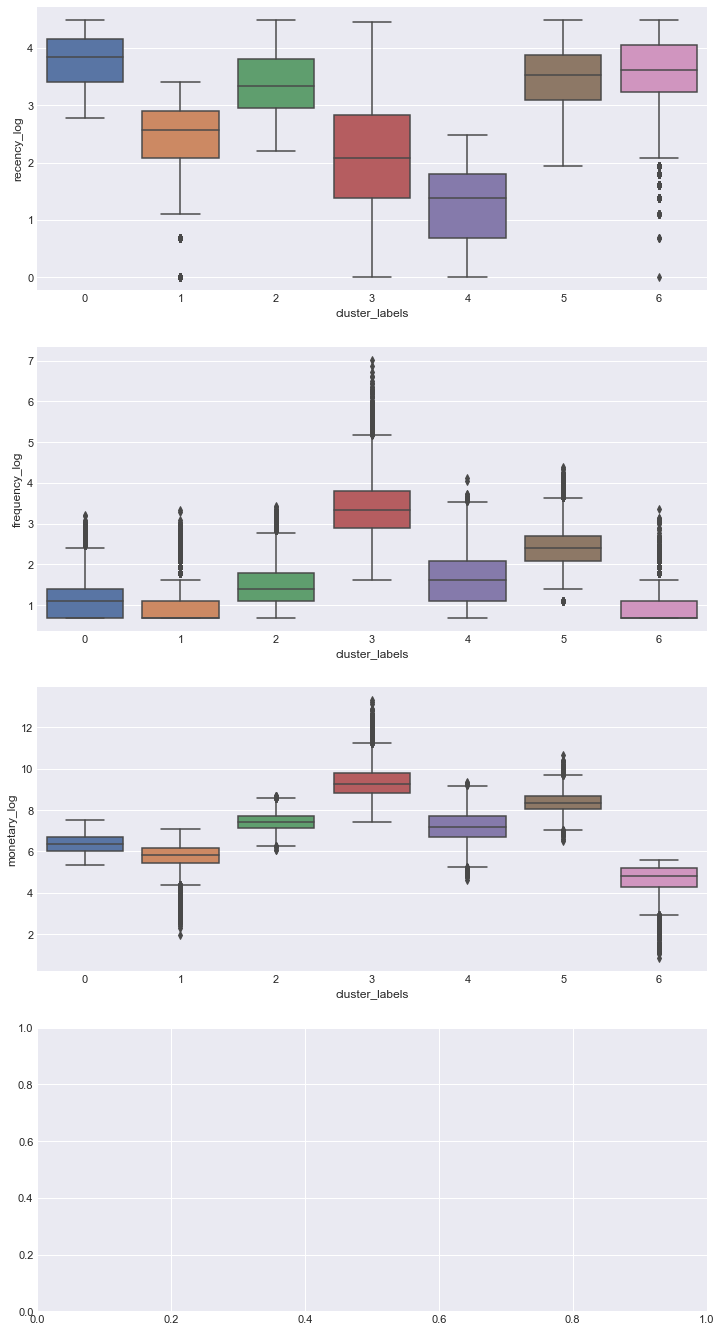

In [203]:
# From above, it seems like the clusters do show clear distinction. Let's see the distribution as a boxplot
_, axes = plt.subplots(len(X_rfm_plot.columns), 1, figsize=(12, 24))

for ind, column in enumerate(X_rfm_df.columns):
    sns.boxplot(x="cluster_labels", y=column, data=X_rfm_plot, ax=axes[ind]); 

In [205]:
# count the number of users in each cluster
X_rfm_output.groupby('cluster_labels').size()

cluster_labels
0    87434
1    50601
2    72365
3    15857
4    36591
5    37218
6    38692
dtype: int64

### Interpretations

High Value, High Risk = Cluster 5

As seen in the boxplot above, they have high frequency, monetary, and also high recency (days_from_last_purchase)

In [206]:
X_output_summary = X_rfm_output.groupby('cluster_labels').agg({
                                'recency_log': ['mean', 'min', 'max', 'sum'],
                                'frequency_log': ['mean', 'min', 'max', 'sum'],
                                'monetary_log': ['mean', 'min', 'max', 'sum'],
                                })

In [207]:
X_output_summary

recency_log                                    frequency_log  \
                      mean       min       max            sum          mean   
cluster_labels                                                                
0                 3.789618  2.772589  4.488636  331341.472861      1.104132   
1                 2.418316  0.000000  3.401197  122369.209045      0.999031   
2                 3.356676  2.197225  4.488636  242905.883070      1.494460   
3                 2.036766  0.000000  4.442651   32297.004402      3.380742   
4                 1.217063  0.000000  2.484907   44533.559766      1.611586   
5                 3.473930  1.945910  4.488636  129292.724790      2.385184   
6                 3.586365  0.000000  4.488636  138763.616474      0.913010   

                                                  monetary_log            \
                     min       max            sum         mean       min   
cluster_labels                                                             
0               0.693147  3.218876   96538.698772     6.365272  5.354414   
1               0.693147  3.332205   50551.983695     5.765509  1.934416   
2               0.693147  3.433987  108146.590846     7.427246  6.084795   
3               1.609438  7.016610   53608.418684     9.358736  7.428161   
4               0.693147  4.110874   58969.530830     7.196832  4.598448   
5               1.098612  4.394449   88771.761445     8.389174  6.490040   
6               0.693147  3.367296   35326.189143     4.665175  0.841567   

                                          
                      max            sum  
cluster_labels                            
0                7.524712  556541.221808  
1                7.082347  291740.512470  
2                8.700314  537472.684218  
3               13.314293  148401.476436  
4                9.342175  263339.276166  
5               10.676222  312228.280237  
6                5.603115  180504.958046

In [204]:
# saving dataframe into parquet file to be exported into local (just in case)
X_rfm_output.to_parquet("C:\\Users\\sakina.sakdun\\Documents\\GitHub\\IOD\\Projects\\capstone\\X_rfm_clusters.parquet.gzip", compression='gzip') 

# Combined

In [208]:
manual_rfm_df.head()

,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
user_id,,,,,,,
515947667,85,2,1174.18,1,1,3,113
546464554,77,4,649.79,1,2,2,122
587615207,75,3,980.47,1,2,3,123
582417846,86,2,3265.96,1,1,4,114
556605306,83,3,800.01,1,2,2,122


In [209]:
# combining manual groups and cluster labels
combined_df = manual_rfm_df

In [210]:
combined_df['cluster_labels'] = X_rfm_output['cluster_labels']

In [211]:
combined_df.head()

,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,cluster_labels
user_id,,,,,,,,
515947667,85,2,1174.18,1,1,3,113,0
546464554,77,4,649.79,1,2,2,122,0
587615207,75,3,980.47,1,2,3,123,0
582417846,86,2,3265.96,1,1,4,114,2
556605306,83,3,800.01,1,2,2,122,0


In [215]:
# saving dataframe into parquet file to be exported into local (just in case)
combined_df.to_parquet("C:\\Users\\sakina.sakdun\\Documents\\GitHub\\IOD\\Projects\\capstone\\combined_clusters.parquet.gzip", compression='gzip') 

# Compare Cluster Results

In [213]:
## from manual groups
# y_true: RFM scores of '144', '134', '143' --> these are clearly low recency, high frequency, high monetary = high value, high risk
highhigh = len(manual_rfm_df[manual_rfm_df['RFMScore']=='144']) + len(manual_rfm_df[manual_rfm_df['RFMScore']=='134']) + len(manual_rfm_df[manual_rfm_df['RFMScore']=='143'])
print(highhigh)

14409


In [214]:
totalcustomers = len(rfm_df)
print(totalcustomers)

338758


## Accuracy Score

In [220]:
# we want to compare the true labels (manual groups) and cluster 5
high_df = combined_df[(combined_df.RFMScore == '144') | (combined_df.RFMScore == '134') | (combined_df.RFMScore == '143')]

In [221]:
# only those identified as high value, high risk
high_df.shape

(14409, 8)

In [222]:
# a function to say is cluster is 5, then true
def iscluster(a):
    if a == 5:
        return 1
    else:
        return 0

In [224]:
high_df['y_pred'] = high_df['cluster_labels'].apply(iscluster)

C:\Users\sakina.sakdun\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [225]:
high_df.head()

,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,cluster_labels,y_pred
user_id,,,,,,,,,
574220964,78,7,2527.40,1,4,4,144,5,1
599279817,75,12,1420.33,1,4,3,143,2,0
592122641,75,5,2184.18,1,3,4,134,2,0
575110953,81,6,4344.09,1,3,4,134,5,1
568528576,80,13,2282.77,1,4,4,144,5,1


In [226]:
# because we already filter it out above, so all are true values
high_df['y_true'] = 1

C:\Users\sakina.sakdun\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [227]:
high_df.head()

,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,cluster_labels,y_pred,y_true
user_id,,,,,,,,,,
574220964,78,7,2527.40,1,4,4,144,5,1,1
599279817,75,12,1420.33,1,4,3,143,2,0,1
592122641,75,5,2184.18,1,3,4,134,2,0,1
575110953,81,6,4344.09,1,3,4,134,5,1,1
568528576,80,13,2282.77,1,4,4,144,5,1,1


In [228]:
y_true = high_df['y_true']
y_pred = high_df['y_pred']

In [229]:
accuracy = accuracy_score(y_true, y_pred)
print("accuracy score: " + str(round(accuracy, 2)))

accuracy score: 0.67


# Potential Revenue Loss

If high value, high risk cluster from MiniBatchKMeans were to churn, we can assume that the company will lose the revenue that could have been generated if some action was done (marketing campaigns, etc)

In [248]:
combined_df.head()

,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,cluster_labels
user_id,,,,,,,,
515947667,85,2,1174.18,1,1,3,113,0
546464554,77,4,649.79,1,2,2,122,0
587615207,75,3,980.47,1,2,3,123,0
582417846,86,2,3265.96,1,1,4,114,2
556605306,83,3,800.01,1,2,2,122,0


In [249]:
combined_df.dtypes

recency             int64
frequency           int64
monetary          float64
R_Quartile          int64
F_Quartile          int64
M_Quartile          int64
RFMScore           object
cluster_labels      int32
dtype: object

In [253]:
rev_loss_df = combined_df[combined_df.cluster_labels == 5]

In [257]:
# removing those which are potentially retained'
rev_loss_df = rev_loss_df[~rev_loss_df['RFMScore'].isin(['144', '134', '143'])]

In [258]:
rev_loss_df.head()

,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,cluster_labels
user_id,,,,,,,,
564258005,75,4,5975.16,1,2,4,124,5
521997451,75,4,4501.51,1,2,4,124,5
553903240,81,4,5599.61,1,2,4,124,5
533943419,76,4,5579.45,1,2,4,124,5
588808457,84,4,4024.80,1,2,4,124,5


In [259]:
len(rev_loss_df)

27540

In [260]:
37218/totalcustomers

0.10986604006399849

In [262]:
rev_loss = np.sum(rev_loss_df['monetary'])

In [263]:
# amount of potential revenue loss
rev_loss

136001129.82

In [264]:
rev_loss / 10**6 # in millions

136.00112982

In [265]:
# total revenue
revenue

963592213.840032

In [274]:
print("potential loss of revenue in %: " + str(round((rev_loss / revenue * 100), 2)))

potential loss of revenue in %: 14.11


 This is the successful model that we have been trying to get :)